# Segmentation Training Notebook

Setup. Make sure to put the appropriate paths in caffe_root and trained_dir

In [2]:
from pylab import *
%matplotlib inline

# this file should be run from {caffe_root}/examples (otherwise change this line)
caffe_root = '/home/jeremy/caffe/' 
trained_dir = '/home/jeremy/trained_nets/'

training_session_name = 'membrane_color'

import sys
import os
sys.path.insert(0, caffe_root + 'python')
import caffe

#Setup destination folder
if not os.path.exists(trained_dir + training_session_name):
    os.makedirs(trained_dir + training_session_name)
    
trained_dir =trained_dir + training_session_name + '/'

/home/jeremy/anaconda/envs/exm_sim/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Choose a simulation stack and its ground truth:

In [3]:
data_path = '/home/jeremy/Desktop/brainbow_cyto_dense.tif'
gt_path = '/home/jeremy/Desktop/brainbow_cyto_dense_gt.tif'

Now create batches from data:

In [4]:
#os.environ['LMDB_FORCE_CFFI'] = '1'
import lmdb
from tifffile import imread
import ipywidgets as widgets
from IPython.display import display

# Parameters
N = 200000 #number of batches to create
window_size = 33
num_channels = 3

# Create data
X = np.zeros((N, num_channels, window_size, window_size), dtype=np.uint8)
y = np.zeros(N, dtype=np.int64)

data = np.rollaxis(imread(data_path), 3, 1)#optional
ground_truth = imread(gt_path)

#Progress bar
progressbar = widgets.FloatProgress(value=0,min=0, max=N ,step=1, description='Loading:',)
display(progressbar)

positives = 0
negatives = 0
img_index = 0
while positives + negatives < N:
    img = data[img_index]
    gt_img = ground_truth[img_index]
    num_channel, width, height = img.shape
    for i in range(window_size, width - window_size):
        if positives + negatives == N: break
        for j in range(window_size, height - window_size):
            if positives + negatives == N: break
            label = gt_img[i + window_size / 2, j + window_size / 2] > 0
            #Ensure we have same amount of positives and negatives
            if label == 0 and positives < negatives:
                continue       
            X[positives + negatives,:,:,:] = img[:, i : i + window_size, j : j +  window_size]
            y[positives + negatives] = label
            progressbar.value = positives + negatives
            if label == 1: 
                positives += 1
            else:
                negatives += 1
    img_index = img_index + 1

indices = [i for i in range(N)]
np.random.shuffle(indices)
X = X[indices, : , :, :]
y = y[indices]

10006
9994


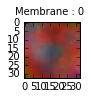

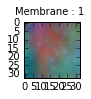

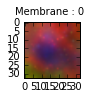

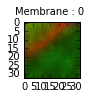

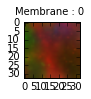

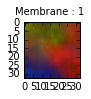

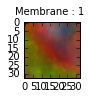

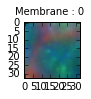

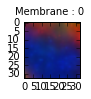

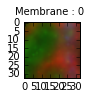

In [4]:
print positives
print negatives
for slice_id in range(6, 20000, 2000):
    fig = figure(figsize=(1, 1))
    fig.text(0, 1, "Membrane : " + str(y[slice_id]))
    imshow(np.swapaxes(X[slice_id,:,:,:], 0, 2))

Now create database containing training data

In [5]:
# We need to prepare the database for the size. We'll set it 10 times
# greater than what we theoretically need. There is little drawback to
# setting this too big. If you still run into problem after raising
# this, you might want to try saving fewer entries in a single
# transaction.
map_size = X.nbytes * 10

train_db_path = trained_dir + training_session_name + '_train_lmdb'
test_db_path = trained_dir + training_session_name + '_test_lmdb'

for db_path in [train_db_path, test_db_path]:
    
    data_to_read = X[: N / 2,:,:,:] if db_path == train_db_path else X[N / 2:,:,:,:]
    print data_to_read.shape
    env = lmdb.open(db_path, map_size=map_size)

    with env.begin(write=True) as txn:
        # txn is a Transaction object
        for i in range(N / 2):
            datum = caffe.proto.caffe_pb2.Datum()
            datum.channels = data_to_read.shape[1]
            datum.height = data_to_read.shape[2]
            datum.width = data_to_read.shape[3]
            datum.data = data_to_read[i].tobytes()  # or .tostring() if numpy < 1.9
            datum.label = int(y[i])
            str_id = '{:08}'.format(i)

            # The encode is only essential in Python 3
            txn.put(str_id.encode('ascii'), datum.SerializeToString())
X = None
y = None

(100000, 3, 33, 33)
(100000, 3, 33, 33)


Compute image mean

In [6]:
cmd = caffe_root + 'build/tools/compute_image_mean ' + train_db_path +\
' ' + trained_dir + 'train_mean_image.binaryproto'
os.system(cmd)
cmd = caffe_root + 'build/tools/compute_image_mean ' + test_db_path +\
' ' + trained_dir + 'test_mean_image.binaryproto'
os.system(cmd)

0

Define the neural net here:

In [10]:
from caffe import layers as L, params as P
from caffe.proto import caffe_pb2 

def lenet(lmdb, batch_size, deploy=False, test=False):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    mean_dir = trained_dir + 'train_mean_image.binaryproto'\
        if not test else trained_dir+ 'test_mean_image.binaryproto'
    if deploy==False:
        n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,\
                             transform_param=dict(mean_file=mean_dir), ntop=2)
        # produce data definition for deploy net
    else:
        the_shape = caffe_pb2.BlobShape(dim = (1, num_channels, window_size, window_size))
        n.data = L.Input(shape= the_shape)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=32, pad=2, stride=1,\
            weight_filler=dict(type='gaussian', std=0.0001), bias_filler=dict(type='constant'))
    n.relu1 = L.ReLU(n.conv1, in_place=True)
    n.pool1 = L.Pooling(n.relu1, kernel_size=3, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=32, pad=2, stride=1,\
            weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant'))
    n.relu2 = L.ReLU(n.conv2, in_place=True)
    n.pool2 = L.Pooling(n.relu2, kernel_size=3, stride=2, pool=P.Pooling.AVE)
    n.conv3 = L.Convolution(n.pool2, kernel_size=5, num_output=64, pad=2, stride=1,\
            weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant'))
    n.relu3 = L.ReLU(n.conv3, in_place=True)
    n.pool3 = L.Pooling(n.relu3, kernel_size=3, stride=2, pool=P.Pooling.AVE)
    n.fc1 =   L.InnerProduct(n.pool3, num_output=64,\
                weight_filler=dict(type='gaussian', std=0.1), bias_filler=dict(type='constant'))
    n.relu4 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu4, num_output=2,\
                weight_filler=dict(type='gaussian', std=0.1), bias_filler=dict(type='constant'))
    
    if deploy==False:
        n.loss = L.SoftmaxWithLoss(n.score, n.label)
    #for generating the deploy net
    else:
        n.prob = L.Softmax(n.score)
    return n.to_proto()

def N4(lmdb, batch_size, deploy=False, test=False):
    
    n = caffe.NetSpec()
    mean_dir = trained_dir + 'train_mean_image.binaryproto'\
        if not test else trained_dir+ 'test_mean_image.binaryproto'
    if deploy==False:
        n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,\
                              transform_param=dict(mean_file=mean_dir), ntop=2)
        # produce data definition for deploy net
    else:
        the_shape = caffe_pb2.BlobShape(dim = (1, num_channels, window_size, window_size))
        n.data = L.Input(shape= the_shape)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, stride = 1, num_output= 32, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, stride = 1, num_output= 32, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride= 2, pool=P.Pooling.MAX)
    #n.conv3 = L.Convolution(n.pool2, kernel_size=4, stride = 1, num_output= 48, weight_filler=dict(type='xavier'))
    #n.pool3 = L.Pooling(n.conv3, kernel_size=2, stride= 2, pool=P.Pooling.MAX)
    #n.conv4 = L.Convolution(n.pool3, kernel_size=4, num_output= 48, weight_filler=dict(type='xavier'))
    #n.pool4 = L.Pooling(n.conv4, kernel_size=2, stride= 2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool2, num_output=64, weight_filler=dict(type='xavier'))
    n.score = L.InnerProduct(n.fc1, num_output=2, weight_filler=dict(type='xavier'))

    if deploy==False:
        n.loss = L.SoftmaxWithLoss(n.score, n.label)
    #for generating the deploy net
    else:
        n.prob = L.Softmax(n.score)
    return n.to_proto()
    

train_path = trained_dir + 'train_'+ training_session_name +'.prototxt'
test_path = trained_dir + 'test_'+ training_session_name +'.prototxt'
deploy_path = trained_dir + 'deploy_'+ training_session_name +'.prototxt'

with open(train_path, 'w') as f:
    f.write(str(N4(train_db_path, 1000, deploy=False, test=False)))
    
with open(test_path, 'w') as f:
    f.write(str(N4(test_db_path, 1000, deploy=False, test=True)))
    
with open(deploy_path, 'w') as f:
    f.write(str(N4('', 1, deploy=True, test=False)))

Define solver below :

In [11]:
def solver(train_net_path, test_net_path=None, base_lr=0.001):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 100  # Test after every 500 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.

    #s.random_seed = 0xCAFFE
    #s.iter_size = 1
    
    s.max_iter = 2500     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'SGD'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'fixed'
    #s.gamma = 0.1
    #s.stepsize = 30

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.99
    s.weight_decay = 5e-4

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 50

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 500
    s.snapshot_prefix = trained_dir + training_session_name
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.CPU
    
    return s

def solver2(train_net_path, test_net_path=None, base_lr=0.0001):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 500  # Test after every 500 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.

    #s.random_seed = 0xCAFFE
    
    s.max_iter = 100     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'SGD'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'inv'
    s.gamma = 0.0001
    s.power = 0.75

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.99
    s.weight_decay = 5e-4

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 10

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 500
    s.snapshot_prefix = trained_dir + training_session_name
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.CPU
    
    return s

solver_path = trained_dir + 'solver_' + training_session_name + '.prototxt'
with open(solver_path, 'w') as f:
    f.write(str(solver2(train_path, test_path)))

Prepare training nets :

Iteration 0 testing...
Iteration 1 testing...
Iteration 2 testing...
Iteration 3 testing...
Iteration 4 testing...
Iteration 5 testing...
Iteration 6 testing...
Iteration 7 testing...
Iteration 8 testing...
Iteration 9 testing...


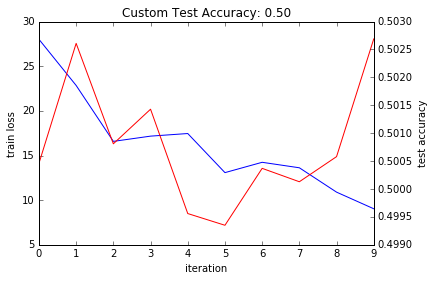

In [12]:
import numpy as np
### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.get_solver(solver_path)

### solve
niter = 10  # EDIT HERE increase to train for longer
test_interval = niter/ 10
# losses will also be stored in the log
train_loss = np.zeros(niter)
test_acc = np.zeros(int(np.ceil(niter / test_interval)))


# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration ' + str(it) + ' testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / (100.0 * 1000.0)

_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Custom Test Accuracy: {:.2f}'.format(test_acc[-1]))

In [24]:
print test_acc

[ 0.5085  0.5031  0.4987  0.4913  0.4919  0.4964  0.4942  0.4999  0.5031
  0.495 ]


In [26]:
print solver.net.blobs['conv1'].data 



AttributeError: 'function' object has no attribute 'net'

In [27]:
solver.net.blobs['data'].data

AttributeError: 'function' object has no attribute 'net'